In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

print("Using TF version", tf.__version__)
print("Seeing GPUs:", tf.config.list_physical_devices('GPU'))

Using TF version 2.6.0
Seeing GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
base_dir = "master_thesis/datasets"

df = pd.read_csv(f"{base_dir}/train_1_100_hardness.csv")
df.head()

,miRNA,gene,label,model_1,model_2,model_3,model_4,model_5,hardness
0,ACCCTATCAATATTGTCTCT,TCTAGTGAAGATGATGAGCTGGTAGAAGAGAAGAAGCAGCAACGAA...,0,0.417197,0.115807,0.376320,0.021328,0.339230,0.467126
1,CAGTGCAATAGTATTGTCAA,CCCCTCTGCCCTGGACTTTCCCATGAGCCTCCTGGAACTGCCAGCC...,0,0.002458,0.000596,0.000301,0.000491,0.001324,0.286453
2,TAAAGTGCTTATAGTGCAGG,GACGTGCTGAAGCTGGGAGAGCAGAAACAGGCAGAGGCTGGAGAGA...,0,0.934873,0.551668,0.140858,0.502673,0.857216,0.712470
3,CTAGGTATGGTCCCAGGGAT,AGCTCATGGTCTCAGAAGGCTGGAAGGATGCAGGTTATGAGTACCT...,0,0.095796,0.135030,0.128284,0.003566,0.004440,0.338159
4,AGCTCGGTCTGAGGCCCCTC,CAGGGAAGGAGACCGTCAGGCCGCATGTAGACAATGCTGCTAAGAA...,0,0.409002,0.050827,0.307442,0.121539,0.356426,0.463605


## Helper functions

These functions should be moved into library!

In [4]:
def encode_ohe_matrix_2d(miRNA, gene, tensor_dim=(50, 20, 1)):  # , categories=False
    """
    fun transform input database to one hot encoding numpy array.

    parameters:
    df = Pandas df with col names "binding_sequence", "label", "mirna_binding_sequence"
    tensor_dim= 2d matrix shape

    output:
    2d dot matrix, labels as np array
    """

    # Check if input sequences have the expected length
    if (len(gene) > tensor_dim[0]) or (len(miRNA) > tensor_dim[1]):
        print(len(gene), tensor_dim[0], len(miRNA), tensor_dim[1])
        return None

    # alphabet for watson-crick interactions.
    alphabet = {"AT": 1., "TA": 1., "GC": 1., "CG": 1.}

    # initialize dot matrix with zeros
    ohe_matrix_2d = np.zeros(tensor_dim, dtype="float32")

    # compile matrix with watson-crick interactions.
    for bind_index, bind_nt in enumerate(gene):
        for mirna_index, mirna_nt in enumerate(miRNA):
            base_pairs = bind_nt + mirna_nt
            ohe_matrix_2d[bind_index, mirna_index, 0] = alphabet.get(base_pairs, 0)

    return ohe_matrix_2d


### Data preprocessing

In [5]:
# Function called in "map" responsible for triggering encoding

def _encode(*row):

  mirna, gene, label = row

  encoded = encode_ohe_matrix_2d(mirna.numpy().decode("utf-8") , gene.numpy().decode("utf-8") , tensor_dim=(50, 20, 1))

  features = tf.convert_to_tensor(encoded, dtype=tf.int8)
  # label = tf.one_hot(int(label), 2, dtype=tf.int8)
  label = int(label)

  return features, label

def _py_func_encode(*x):
  return tf.py_function(_encode, x, [tf.int8, tf.int8])

def _concat_datasets(*x):
  (d1, l1), (d2, l2) = x
  return tf.concat([d1, d2], 0), tf.concat([l1, l2], 0)

In [6]:
def get_dataset(file_path, batch_size=1024, field_delim=','):

  # Load data from csv directly
  default_dtype = [tf.string] * 3 # Load everything as strings
  dataset = tf.data.experimental.CsvDataset(
      [file_path],
      default_dtype,
      header=True, 
      field_delim=field_delim
  )

  # Encode dataset <-- really slow ...
  dataset = dataset.map(_py_func_encode, num_parallel_calls=tf.data.AUTOTUNE)

  # Cache encoded
  dataset = dataset.cache()

  # Shuffle dataset each time to create different batches
  dataset = dataset.shuffle(1000000, reshuffle_each_iteration=True)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

## Exploring hard instances

In [4]:
print("\n\nNumber of hard instances with given 'hardness' threshold")

pd.concat([
    
    df[df['hardness'] > 0.5][['hardness', 'label']].groupby('label').count().rename(columns={"hardness": "> 0.5"}),
    df[df['hardness'] > 0.6][['hardness', 'label']].groupby('label').count().rename(columns={"hardness": "> 0.6"}),
    df[df['hardness'] > 0.7][['hardness', 'label']].groupby('label').count().rename(columns={"hardness": "> 0.7"}),
    df[df['hardness'] > 0.8][['hardness', 'label']].groupby('label').count().rename(columns={"hardness": "> 0.8"}),
    df[df['hardness'] > 0.9][['hardness', 'label']].groupby('label').count().rename(columns={"hardness": "> 0.9"})
    
    ], axis=1)



Number of hard instances with given 'hardness' threshold


,> 0.5,> 0.6,> 0.7,> 0.8,> 0.9
label,,,,,
0,132815,99931,73581,50722,28620
1,3514,3214,2960,2694,2382




Example of hard instances from both classes:


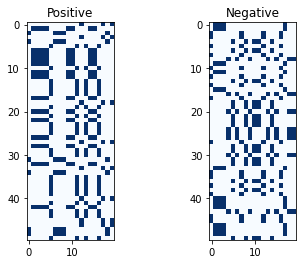

In [46]:
import matplotlib.pyplot as plt

# Encode and plot random hard instances

index_p = df[(df['hardness'] > 0.9) & (df['label'] == 1)].sample(n=1).index[0]
index_n = df[(df['hardness'] > 0.9) & (df['label'] == 0)].sample(n=1).index[0]

sample_p = df.iloc[index_p]
sample_n = df.iloc[index_n]

sample_p = encode_ohe_matrix_2d(sample_p['miRNA'], sample_p['gene'])
sample_n = encode_ohe_matrix_2d(sample_n['miRNA'], sample_n['gene'])

print("\n\nExample of hard instances from both classes:")

f, ax = plt.subplots(1, 2)
ax[0].imshow(sample_p.squeeze(), cmap='Blues')
ax[0].set_title(f"Positive")

ax[1].imshow(sample_n.squeeze(), cmap='Blues')
ax[1].set_title(f"Negative")

plt.show()

## Retraining

To validate the effect of retraining using hard instances, we will repeat each retraining method with randomly sampled data.

### Whole network retraining

In this experiment the whole network is retrained. We will retrain the network using these data:

| ratio 	| class weight 	|
|-------	|--------------	|
| 1:1   	| 1:1          	|
| 1:100 	| 1:1          	|
| 1:100 	| 1:100        	|

#### Hardness > 0.9

##### Generating training datasets

Since a preprocessing pipeline from csv exists, we will generate training CSVs,

In [27]:
num_positive = len(df[df['label'] == 1])
print("Number of positive samples is", num_positive)

NameError: name 'df' is not defined

In [79]:
df_ = pd.concat([
    df[(df['hardness'] > 0.9) & (df['label'] == 0)].sample(n=num_positive),
    df[df['label'] == 1].sample(frac=1.)
    ], axis=0)[['miRNA', 'gene', 'label']]
df_.reset_index(inplace=True)
del df_['index']
df_

,miRNA,gene,label
0,CAAATTCGTATCTAGGGGAA,AAGGAAGGAGATATAGTGAAGAGGACAGGAGCCATTGTGGACGTTC...,0
1,AATTGCACGGTATCCATCTG,AGTGGCAGCAGAGGATGAGGAAAATGTCGCAGGAGGTTTGCACATT...,0
2,CAACGGAATCCCAAAAGCAG,CAGAGAGAGGCCCACGGCTGTTTCTTGAAATCTGGCGCTGGGAATG...,0
3,AACTGGCCTACAAAGTCCCA,CTTAGTGCACAAGCCTACCTTCTTTTCTATGAAAGAGTATTATAAC...,0
4,TAAGGTGCATCTAGTGCAGA,TGCACGAGCTGAAGGACCTGCGGGAGTATGACACAGCCGAGGCCCA...,0
...,...,...,...
30779,TGAGGTAGTAGGTTGTGTGG,GAGCCAGGCCTACACCCCAGCAACCATGTCCAAGGGACCTGCAGTT...,1
30780,TAGCAGCACATCATGGTTTA,GTGTGCTGCGGTTCATCATGGAGAGTGGGGCCAAAGGCTGCGAGGT...,1
30781,ACTGCATTATGAGCACTTAA,GCTGAGGTGCTCATGGTGGAGGTAGAGAACGTTGTCCACGAGGACT...,1
30782,TGAGGTAGTAGGTTGTGTGG,CTAATTCTTCATTGGAAGCCACTCCCTTCACCTCACCTCACCTAGT...,1


In [80]:
df_.to_csv(f"{base_dir}/train_1_1_90_random.csv", index=False)

##### Training models

1. model is retrained on `train_1_1_90.csv` which contains hard negative instances and all positive instances in ratio 1:1
2. model is trained on randomly sampled data with ratio 1:1

In [6]:
base_dir = "master_thesis/datasets"
train_dataset_random = get_dataset(f"{base_dir}/train_1_1_90_random.csv", batch_size=1024)
train_dataset = get_dataset(f"{base_dir}/train_1_1_90.csv", batch_size=1024)
val_dataset = get_dataset(f"{base_dir}/evaluation_set_CLASH2013_paper.tsv", batch_size=1024, field_delim="\t")

Let's encode test dataset separately, to get labels more easily.

In [7]:
def encode_and_label(row):
    return encode_ohe_matrix_2d(row['miRNA'], row['gene']), row['label']

In [8]:
from tqdm.notebook import tqdm

test_df_100 = pd.read_csv(f"{base_dir}/test_set_1_100_CLASH2013_paper.tsv", sep="\t").sample(frac=1.)
test_df_1 = pd.read_csv(f"{base_dir}/test_set_CLASH2013_paper.tsv", sep="\t").sample(frac=1.)

tqdm.pandas(desc="Encoding test data 1:100")
test_data_100 = test_df_100[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

tqdm.pandas(desc="Encoding test data 1:1")
test_data_1 = test_df_1[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

Encoding test data 1:100:   0%|          | 0/202000 [00:00<?, ?it/s]

Encoding test data 1:1:   0%|          | 0/4000 [00:00<?, ?it/s]

Let's train the test (2.) model first.

In [9]:
# Load "base" models
model_random = tf.keras.models.load_model(f'master_thesis/models/1_1_basic_training_shuffle/model_1.h5')
model = tf.keras.models.load_model(f'master_thesis/models/1_1_basic_training_shuffle/model_1.h5')

print("Models loaded")

Models loaded


In [10]:
predictions = {}

predictions['random'] = {}
predictions['select'] = {}

# Get evaluation before retraining
predictions['random']['before'] = {}
predictions['select']['before'] = {}

print("\nPredicting model - random")
predictions['random']['before']['100'] = model_random.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['random']['before']['1'] = model_random.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()

print("\nPredicting model - select")
predictions['select']['before']['100'] = model.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['select']['before']['1'] = model.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()


Predicting model - random
2/2 [==============================] - 0s 312ms/step

Predicting model - select
2/2 [==============================] - 0s 16ms/step


In [11]:
history = model.fit(x=train_dataset, 
            validation_data=val_dataset, 
            verbose=0,
            epochs=100,
            # batch_size=batch_size,
            # steps_per_epoch=1000,
            callbacks=[
              tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0.05,
                patience=25,
                verbose=1,
                mode="min",
                baseline=None,
                restore_best_weights=True,
              ), 
              tf.keras.callbacks.ModelCheckpoint(
                f"./model_1_retrained_select.h5", 
                save_best_only=True, 
                verbose=0
              )
            ])

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


In [12]:
history = model_random.fit(x=train_dataset_random, 
            validation_data=val_dataset, 
            verbose=0,
            epochs=100,
            # batch_size=batch_size,
            # steps_per_epoch=1000,
            callbacks=[
              tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0.05,
                patience=25,
                verbose=1,
                mode="min",
                baseline=None,
                restore_best_weights=True,
              ), 
              tf.keras.callbacks.ModelCheckpoint(
                f"./model_1_retrained_random.h5", 
                save_best_only=True, 
                verbose=0
              )
            ])

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping


In [13]:
# Get evaluation after retraining
predictions['random']['after'] = {}
predictions['select']['after'] = {}

print("Predicting model - random")
predictions['random']['after']['100'] = model_random.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['random']['after']['1'] = model_random.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()

print("Predicting model - select")
predictions['select']['after']['100'] = model.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['select']['after']['1'] = model.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()

Predicting model - random
2/2 [==============================] - 0s 16ms/step
Predicting model - select
2/2 [==============================] - 0s 16ms/step


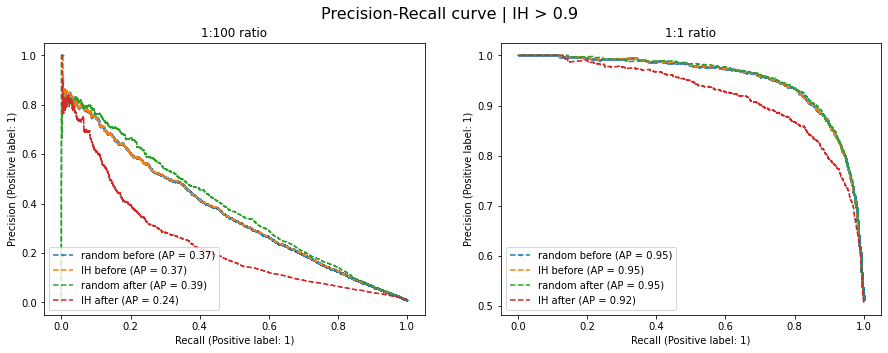

In [26]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2, figsize=(15,5))

f.suptitle("Precision-Recall curve | IH > 0.9", fontsize=16)
y_true = np.array(list(test_data_100[1]))
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['before']['100'], ax=ax[0], name = "random before", marker="x", markersize=1, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['select']['before']['100'], ax=ax[0], name = "IH before", marker=",", markersize=0, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['after']['100'], ax=ax[0], name = "random after", marker="X", markersize=0, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['select']['after']['100'], ax=ax[0], name = "IH after", marker=".", markersize=0, linestyle='--')
_ = ax[0].set_title(f"1:100 ratio")

y_true = np.array(list(test_data_1[1]))
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['before']['1'], ax=ax[1], name = "random before", marker="x", markersize=1, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['select']['before']['1'], ax=ax[1], name = "IH before", marker=",", markersize=0, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['after']['1'], ax=ax[1], name = "random after", marker="X", markersize=0, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['select']['after']['1'], ax=ax[1], name = "IH after", marker=".", markersize=0, linestyle='--')
_ = ax[1].set_title(f"1:1 ratio")


#### Hardness (0.6, 0.9)

##### Generating training datasets

Since a preprocessing pipeline from csv exists, we will generate training CSVs,

In [7]:
num_positive = len(df[df['label'] == 1])
print("Number of positive samples is", num_positive)

Number of positive samples is 15392


In [8]:
df_ = pd.concat([
    df[(df['hardness'] < 0.9) & (df['hardness'] > 0.6) & (df['label'] == 0)].sample(n=num_positive),
    df[df['label'] == 1].sample(frac=1.)
    ], axis=0)[['miRNA', 'gene', 'label']]
df_.reset_index(inplace=True)
del df_['index']
df_

,miRNA,gene,label
0,TAGCAGCACGTAAATATTGG,GCATCATCCCGCGTCATCTCCAACTGGCCATCCGCAACGACGAGGA...,0
1,TACCCTGTAGATCCGAATTT,CAGGGGACCGAGTCTGACAAACACAATACATTTATCTGTGACCTAT...,0
2,AAGCCCTTACCCCAAAAAGT,GCATGGCTGCAGGGTGGACCAGCTGCCTGGCATTCAGGCCCAGATG...,0
3,CGGCGGGGACGGCGATTGGT,GCAGGGACTCCTAGGGGCCCAGTAAGGACAGTGCCCGCCAGGGACC...,0
4,CAAAGTGCTTACAGTGCAGG,CATTGCTGAGTGCCTGGCAGATGAGCTCATCAATGCTGCCAAGGGC...,0
...,...,...,...
30779,GCAAAGCACACGGCCTGCAG,ATTGTCCTCTGCTTTATTTAGCTTAGAAAATCATTCCTTTTTTTTT...,1
30780,TATTGCACTTGTCCCGGCCT,CAATTTATAAATTTATATCTAAAGGGGAATCATGATTATAAGTCCT...,1
30781,TGAGGGGCAGAGAGCGAGAC,CGCTCCAGCAGCTCTGCCCAACCGCAGCCTCGCCGTGGCGGGAGGC...,1
30782,AACTGGCCCTCAAAGTCCCG,CAGAAAGCGGGGAGAAGCCAGAGTTCTTGGCTCAGGACTGAAGGGA...,1


In [10]:
df_.to_csv(f"{base_dir}/train_1_1_60_90.csv", index=False)

##### Training models

1. model is retrained on `train_1_1_60_90.csv` which contains hard negative instances and all positive instances in ratio 1:1
2. model is trained on randomly sampled data with ratio 1:1

In [11]:
base_dir = "master_thesis/datasets"
train_dataset_random = get_dataset(f"{base_dir}/train_1_1_random.csv", batch_size=1024)
train_dataset = get_dataset(f"{base_dir}/train_1_1_60_90.csv", batch_size=1024)
val_dataset = get_dataset(f"{base_dir}/evaluation_set_CLASH2013_paper.tsv", batch_size=1024, field_delim="\t")

Let's encode test dataset separately, to get labels more easily.

In [12]:
def encode_and_label(row):
    return encode_ohe_matrix_2d(row['miRNA'], row['gene']), row['label']

In [13]:
from tqdm.notebook import tqdm

test_df_100 = pd.read_csv(f"{base_dir}/test_set_1_100_CLASH2013_paper.tsv", sep="\t").sample(frac=1.)
test_df_1 = pd.read_csv(f"{base_dir}/test_set_CLASH2013_paper.tsv", sep="\t").sample(frac=1.)

tqdm.pandas(desc="Encoding test data 1:100")
test_data_100 = test_df_100[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

tqdm.pandas(desc="Encoding test data 1:1")
test_data_1 = test_df_1[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

Encoding test data 1:100:   0%|          | 0/202000 [00:00<?, ?it/s]

Encoding test data 1:1:   0%|          | 0/4000 [00:00<?, ?it/s]

In [14]:
# Load "base" models
model_random = tf.keras.models.load_model(f'master_thesis/models/1_1_basic_training_shuffle/model_1.h5')
model = tf.keras.models.load_model(f'master_thesis/models/1_1_basic_training_shuffle/model_1.h5')

print("Models loaded")

Models loaded


In [15]:
predictions = {}

predictions['random'] = {}
predictions['select'] = {}

# Get evaluation before retraining
predictions['random']['before'] = {}
predictions['select']['before'] = {}

print("\nPredicting model - random")
predictions['random']['before']['100'] = model_random.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['random']['before']['1'] = model_random.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()

print("\nPredicting model - select")
predictions['select']['before']['100'] = model.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['select']['before']['1'] = model.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()


Predicting model - random
2/2 [==============================] - 0s 328ms/step

Predicting model - select
2/2 [==============================] - 0s 31ms/step


In [16]:
history = model.fit(x=train_dataset, 
            validation_data=val_dataset, 
            verbose=0,
            epochs=100,
            # batch_size=batch_size,
            # steps_per_epoch=1000,
            callbacks=[
              tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0.05,
                patience=25,
                verbose=1,
                mode="min",
                baseline=None,
                restore_best_weights=True,
              ), 
              tf.keras.callbacks.ModelCheckpoint(
                f"./model_1_retrained_select.h5", 
                save_best_only=True, 
                verbose=0
              )
            ])

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping


In [17]:
history = model_random.fit(x=train_dataset_random, 
            validation_data=val_dataset, 
            verbose=0,
            epochs=100,
            # batch_size=batch_size,
            # steps_per_epoch=1000,
            callbacks=[
              tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0.05,
                patience=25,
                verbose=1,
                mode="min",
                baseline=None,
                restore_best_weights=True,
              ), 
              tf.keras.callbacks.ModelCheckpoint(
                f"./model_1_retrained_random.h5", 
                save_best_only=True, 
                verbose=0
              )
            ])

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping


In [18]:
# Get evaluation after retraining
predictions['random']['after'] = {}
predictions['select']['after'] = {}

print("Predicting model - random")
predictions['random']['after']['100'] = model_random.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['random']['after']['1'] = model_random.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()

print("Predicting model - select")
predictions['select']['after']['100'] = model.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['select']['after']['1'] = model.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()

Predicting model - random
2/2 [==============================] - 0s 16ms/step
Predicting model - select
2/2 [==============================] - 0s 31ms/step


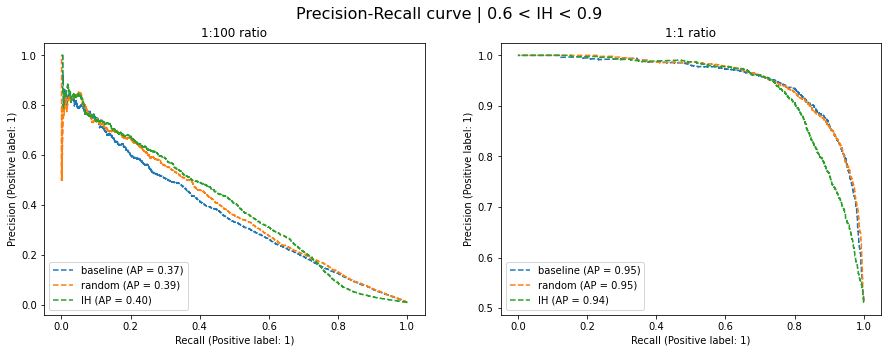

In [23]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2, figsize=(15,5))

f.suptitle("Precision-Recall curve | 0.6 < IH < 0.9", fontsize=16)
y_true = np.array(list(test_data_100[1]))
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['before']['100'], ax=ax[0], name = "baseline", linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['after']['100'], ax=ax[0], name = "random", linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['select']['after']['100'], ax=ax[0], name = "IH", linestyle='--')
_ = ax[0].set_title(f"1:100 ratio")

y_true = np.array(list(test_data_1[1]))
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['before']['1'], ax=ax[1], name = "baseline", linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['after']['1'], ax=ax[1], name = "random", linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['select']['after']['1'], ax=ax[1], name = "IH", linestyle='--')
_ = ax[1].set_title(f"1:1 ratio")


#### Hardness (0.6, 0.9) easy start

In this experiment we will train the base network on "easy" samples (IH < 0.5), then retrain it on hard ones (0.6 < IH < 0.9).

##### Generating training datasets

Since a preprocessing pipeline from csv exists, we will generate training CSVs,

In [24]:
num_positive = len(df[df['label'] == 1])
print("Number of positive samples is", num_positive)

Number of positive samples is 15392


In [25]:
df_ = pd.concat([
    df[(df['hardness'] < 0.5) & (df['label'] == 0)].sample(n=num_positive),
    df[df['label'] == 1].sample(frac=1.)
    ], axis=0)[['miRNA', 'gene', 'label']]
df_.reset_index(inplace=True)
del df_['index']

df_.to_csv(f"{base_dir}/train_1_1_lt_50.csv", index=False)

df_

,miRNA,gene,label
0,CAGTGCAATAGTATTGTCAA,AGATCCTGAGGGCCAGCCGGGAAGGAGGCGTGGATATGGAGCTGGC...,0
1,TGTCTGCCCGCATGCCTGCC,GTCAAGGAGGAGGAGACGGAGGCTGCCATTGGAGCCCCTCCTACTG...,0
2,TGGGTCTTTGCGGGCGAGAT,GCGTCATGGTGGGCATGGGCCAGAAGGACTCCTACGTGGGCGACGA...,0
3,CAACGGAATCCCAAAAGCAG,ACCTGCTCTACCTGCCAGAAATTTTAAAACAAAAACAAAAACAAAA...,0
4,CCGCACTGTGGGTACTTGCT,AGCAGCCGGGACTGCAGGCACAAGCCACCATGCCTGGCTGTTTTTT...,0
...,...,...,...
30779,TGCGGGGCTAGGGCTAACAG,CAGTTCTGCTCATGCCCAATGGCCCCATGCGGATAACCAGTGGTCC...,1
30780,ACTGGACTTGGAGTCAGAAG,GTGCCTCTGCCCATTGTCCATGATTTACACTAATTGTGAGCAGTCT...,1
30781,TCAGGCTCAGTCCCCTCCCG,CCAAGGACGGGACGGGATGGGCAAACAAGCAGGATCAGCAAGACCC...,1
30782,ACTCCAGCCCCACAGCCTCA,AACCACATGGGCTGGGGGCCAGGGCTGGATGGACAGACACCTCCCC...,1


##### Training models

Train a new baseline model on the "easy" dataset.

1. model is retrained on `train_1_1_60_90.csv` which contains hard negative instances and all positive instances in ratio 1:1
2. model is trained on randomly sampled data with ratio 1:1

In [26]:
base_dir = "master_thesis/datasets"

train_dataset_easy = get_dataset(f"{base_dir}/train_1_1_lt_50.csv", batch_size=1024)
train_dataset_random = get_dataset(f"{base_dir}/train_1_1_random.csv", batch_size=1024)
train_dataset = get_dataset(f"{base_dir}/train_1_1_60_90.csv", batch_size=1024)

# We will use just one validation dataset
val_dataset = get_dataset(f"{base_dir}/evaluation_set_CLASH2013_paper.tsv", batch_size=1024, field_delim="\t")

Let's encode test dataset separately, to get labels more easily.

In [27]:
def encode_and_label(row):
    return encode_ohe_matrix_2d(row['miRNA'], row['gene']), row['label']

In [28]:
from tqdm.notebook import tqdm

test_df_100 = pd.read_csv(f"{base_dir}/test_set_1_100_CLASH2013_paper.tsv", sep="\t").sample(frac=1.)
test_df_1 = pd.read_csv(f"{base_dir}/test_set_CLASH2013_paper.tsv", sep="\t").sample(frac=1.)

tqdm.pandas(desc="Encoding test data 1:100")
test_data_100 = test_df_100[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

tqdm.pandas(desc="Encoding test data 1:1")
test_data_1 = test_df_1[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

Encoding test data 1:100:   0%|          | 0/202000 [00:00<?, ?it/s]

Encoding test data 1:1:   0%|          | 0/4000 [00:00<?, ?it/s]

Create new baseline model

In [29]:
from tensorflow.keras import layers

def create_model(sample_shape=(50,20,1), **kwargs):
    DATA_FORMAT = "channels_last"

    main_input = layers.Input(shape=sample_shape,
                              dtype='float32', 
                              # name='main_input'
                        )

    x = layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        data_format=DATA_FORMAT,
        # name="conv_1"
        )(main_input)    
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2),strides=None, 
                            # name='Max_1', 
                            data_format=DATA_FORMAT)(x)
    x = layers.Dropout(rate = 0.10)(x)

    x = layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        data_format=DATA_FORMAT,
        # name="conv_2"
        )(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), 
                            # name='Max_2', 
                            data_format=DATA_FORMAT)(x)
    x = layers.Dropout(rate = 0.15)(x)

    x = layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding="same",
        data_format=DATA_FORMAT,
        # name="conv_3"
        )(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), 
                            # name='Max_3', 
                            data_format=DATA_FORMAT)(x)
    x = layers.Dropout(rate = 0.20)(x)

    conv_flat = layers.Flatten(
        # name='2d_matrix'
        )(x)

    x = layers.Dense(128)(conv_flat)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate = 0.20)(x)

    x = layers.Dense(64)(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate = 0.15)(x)

    x = layers.Dense(32)(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate = 0.10)(x)

    main_output = layers.Dense(1, activation='sigmoid', 
                              #  name='main_output'
                               )(x)

    model = tf.keras.models.Model(inputs=[main_input], outputs=[main_output], **kwargs)
    
    return model

In [30]:
# Load "base" models
model_random = tf.keras.models.load_model(f'master_thesis/models/1_1_basic_training_shuffle/model_1.h5')
model = create_model()

print("Models loaded")

Models loaded


In [31]:
model.compile(**{
      "optimizer": tf.keras.optimizers.Adam(name="adam"),
      "loss": tf.keras.losses.BinaryCrossentropy(),
      # "loss": tf.keras.losses.CategoricalCrossentropy(),
      "metrics": [
                  # tf.keras.metrics.AUC(name="auc")
                  tf.keras.metrics.Precision(name="precision"),
                  tf.keras.metrics.Recall(name="recall")
                ]
  })

history = model.fit(x=train_dataset_easy, 
            validation_data=val_dataset, 
            verbose=0,
            epochs=100,
            # batch_size=batch_size,
            # steps_per_epoch=1000,
            callbacks=[
              tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0.05,
                patience=25,
                verbose=1,
                mode="min",
                baseline=None,
                restore_best_weights=True,
              ), 
              tf.keras.callbacks.ModelCheckpoint(
                f"./model_1_retrained_select_easy_start.h5", 
                save_best_only=True, 
                verbose=0
              )
            ])

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping


In [32]:
predictions = {}

predictions['random'] = {}
predictions['select'] = {}

# Get evaluation before retraining
predictions['random']['before'] = {}
predictions['select']['before'] = {}

print("\nPredicting model - random")
predictions['random']['before']['100'] = model_random.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['random']['before']['1'] = model_random.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()

print("\nPredicting model - select")
predictions['select']['before']['100'] = model.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['select']['before']['1'] = model.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()


Predicting model - random
2/2 [==============================] - 0s 16ms/step

Predicting model - select
2/2 [==============================] - 0s 16ms/step


In [33]:
history = model.fit(x=train_dataset, 
            validation_data=val_dataset, 
            verbose=0,
            epochs=100,
            # batch_size=batch_size,
            # steps_per_epoch=1000,
            callbacks=[
              tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0.05,
                patience=25,
                verbose=1,
                mode="min",
                baseline=None,
                restore_best_weights=True,
              ), 
              tf.keras.callbacks.ModelCheckpoint(
                f"./model_1_retrained_select_easy_start.h5", 
                save_best_only=True, 
                verbose=0
              )
            ])

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping


In [34]:
history = model_random.fit(x=train_dataset_random, 
            validation_data=val_dataset, 
            verbose=0,
            epochs=100,
            # batch_size=batch_size,
            # steps_per_epoch=1000,
            callbacks=[
              tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0.05,
                patience=25,
                verbose=1,
                mode="min",
                baseline=None,
                restore_best_weights=True,
              ), 
              tf.keras.callbacks.ModelCheckpoint(
                f"./model_1_retrained_random.h5", 
                save_best_only=True, 
                verbose=0
              )
            ])

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping


In [35]:
# Get evaluation after retraining
predictions['random']['after'] = {}
predictions['select']['after'] = {}

print("Predicting model - random")
predictions['random']['after']['100'] = model_random.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['random']['after']['1'] = model_random.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()

print("Predicting model - select")
predictions['select']['after']['100'] = model.predict(np.array(list(test_data_100[0])), batch_size=2048, verbose=1).squeeze()
predictions['select']['after']['1'] = model.predict(np.array(list(test_data_1[0])), batch_size=2048, verbose=1).squeeze()

Predicting model - random
2/2 [==============================] - 0s 16ms/step
Predicting model - select
2/2 [==============================] - 0s 28ms/step


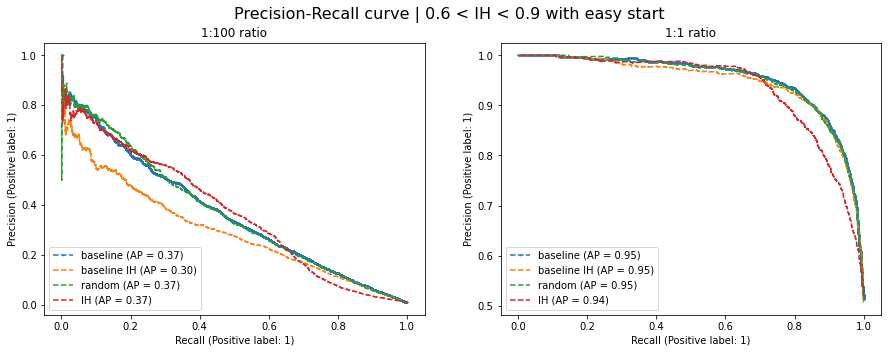

In [37]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2, figsize=(15,5))

f.suptitle("Precision-Recall curve | 0.6 < IH < 0.9 with easy start", fontsize=16)
y_true = np.array(list(test_data_100[1]))
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['before']['100'], ax=ax[0], name = "baseline", marker="x", markersize=1, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['select']['before']['100'], ax=ax[0], name = "baseline IH", marker=",", markersize=0, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['after']['100'], ax=ax[0], name = "random", marker="X", markersize=0, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['select']['after']['100'], ax=ax[0], name = "IH", marker=".", markersize=0, linestyle='--')
_ = ax[0].set_title(f"1:100 ratio")

y_true = np.array(list(test_data_1[1]))
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['before']['1'], ax=ax[1], name = "baseline", marker="x", markersize=1, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['select']['before']['1'], ax=ax[1], name = "baseline IH", marker=",", markersize=0, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['random']['after']['1'], ax=ax[1], name = "random", marker="X", markersize=0, linestyle='--')
_ = PrecisionRecallDisplay.from_predictions(y_true, predictions['select']['after']['1'], ax=ax[1], name = "IH", marker=".", markersize=0, linestyle='--')
_ = ax[1].set_title(f"1:1 ratio")
